In [5]:
import numpy as np
import scipy as sp
from scipy.integrate import trapz
from matplotlib import pyplot as plt
%matplotlib widget


## Problem 1

In [6]:
# Problem 1
def get_T0(T1, Tint, lambda_bound):
    return (lambda_bound * T1 + Tint) / (1 + lambda_bound)

In [7]:
###### Initialize Constants ######
rho = 1.225
Cp = 1005
V = 2880
delt = 15
Eint = 250
Ev = -500
T0 = 293.15

rhof = 2300
Cf = 750
kf = 0.8
Af = 90
th = 0.10
h = 4
delx = 0.010
Tf = 293.15
tsim = 4 * 24 * 60 * 60
times = np.arange(0, tsim + delt, delt)
N = len(times)
x = np.arange(0, th + delx, delx)

times = np.arange(0, 96 * 60 * 60 + delt, delt)
N = len(times)
Tints = np.zeros(N) # initializing interior air temp vector
Tints[0] = T0

lambda_int = delt / (rho * Cp * V) #scaling for ODE of interior temp

lambda_val = (kf * delt) / (rhof * Cf * delx**2) #scaling for ODE of wall temp
lambda_bound = kf / (h * delx) #boundary scaling for ODE of wall temp

n = round(th / delx) - 1 #number of nodes in wall
r = np.zeros(n) #initializing first row of A, which is ODE matrix discretized
r[0] = 1 - 2 * lambda_val
r[1] = lambda_val
r[-1] = lambda_val

A = sp.linalg.toeplitz(r)

A[0, 0] = A[0, 0] + lambda_val * lambda_bound / (1 + lambda_bound) # adjusting for boundary condition 
A[-1, -1] = A[0, 0] # adjusting for boundary condition
A[-1, 0] = 0
A[0, -1] = 0


###########################
# Plot the color plot
import plotly.graph_objs as go
import plotly.express as px
# Create a heatmap figure
fig = go.Figure(data=go.Heatmap(z=A, colorscale='Viridis'))

# Update layout
fig.update_layout(
    title='Heatmap of Matrix',
    xaxis_title='X-axis',
    yaxis_title='Y-axis'
)

# Show the figure
fig.show()
###########################

b = np.zeros(n) #initializing forcing as zeros

T = np.ones(n) * Tf #initializing T vector for wall temp

T0s = np.zeros(N) #initializing T0 vector for tracking surface temp (not a node)
T0s[0] = Tf 
T_profs = np.zeros((n + 2, 6)) # intializing matrix to store 6 temperature profiles


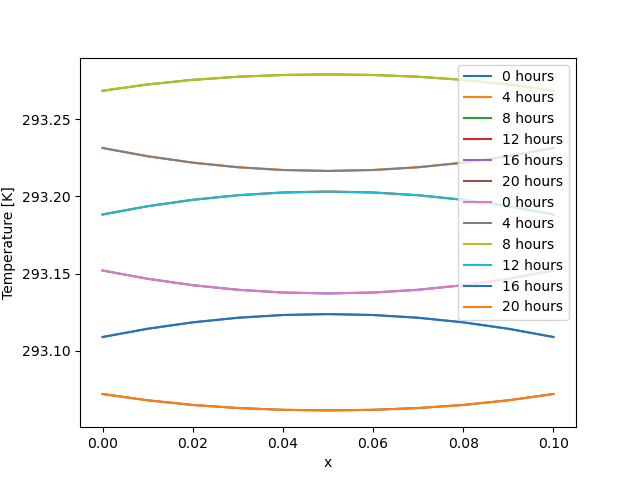

In [8]:
tHour = 60 * 60
hours = times / tHour

for i in range(1, N):
    t = times[i]
    hour = hours[i]
    if (hour % 24 > 7) and (hour % 24 < 19): #daytime
        Evt = Ev
    else:
        Evt = 0

    Tint = Tints[i - 1]
    b[0] = lambda_val * Tint / (1 + lambda_bound) # adding forcing term for boundary condition
    b[-1] = b[0] # adding forcing term for boundary condition (assuming symmetry)
    T = np.dot(A, T) + b # solving for wall temp
    T0s[i] = get_T0(T[0], Tint, lambda_bound) # updating surface temp
    #### Numerical precision issue from HW!!!! ####
    # Ef = 6 * Af * (T[0] - T0s[i]) / delx # calculating wall into air
    ######## BOTH below give equivalent results ######
    # Ef = 6 * Af * (T0s[i] - Tint) * h # calculating wall into air
    Ef = 6 * Af * (kf/delx*(T[0] - Tint)/(1 + lambda_bound)) # calculating wall into air

    
    Tints[i] = Tint + lambda_int * (Ef + Eint + Evt) # updating interior air temp

    if (hour % 4 == 0) and (hour >= 24 * 2) and (hour < 24 * 3):
        hour_time = hour % 24
        T_profs[1:-1, int(hour_time / 4)] = T
        T_profs[0, int(hour_time / 4)] = get_T0(T[0], Tint, lambda_bound)
        T_profs[-1, int(hour_time // 4)] = get_T0(T[-1], Tint, lambda_bound)

# Plotting
plt.figure(1)
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T0s, label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure(2)
for i in range(6):
    plt.plot(x, T_profs[:, i], label=f'{(i * 4) % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

## Problem 3

This is just calculating ventilation rates, and not doing any ODE solving

In [5]:
# Problem 2
def get_Wpivot(z, alpha, W, H):
    h = H * (1 - np.cos(alpha))
    Wpivot = np.ones_like(z) * W
    zpivot = z[z > h]
    Wpivot[z > h] = (1 / W**2 + 1 / (2 * (H - zpivot) * np.tan(alpha) + np.sin(alpha) * W**2))**(-1/2)
    return Wpivot

def get_Aeff(alpha, W, H):
    z = np.linspace(0, H, 1000)
    Wpivot = get_Wpivot(z, alpha, W, H)
    return trapz(Wpivot, z)

# B
def get_Cd(alpha, W, H):
    Cd0 = 0.611
    return get_Aeff(alpha, W, H) / (H * W) * Cd0

# Problem 3
def get_Vnvi(Cdi, Ai, Li, Tint, Tout):
    g = 9.8 # grrvity
    return Cdi * Ai * (2 * g * Li * np.abs((Tint - Tout) / Tout))**0.5 #ventilation rate calculation

def get_Vnv(Cd, A, L, Tint, Tout, t):
    Vnv = np.zeros((Cd.size, t.size)) #initializing matrix of ventilation rates
    hours = t / 60 / 60
    day_hours = np.remainder(hours, 24) #time of day
    Tint = Tint[(day_hours < 7) | (day_hours > 12 + 7)]
    Tout = Tout[(day_hours < 7) | (day_hours > 12 + 7)]
    for i in range(3):
        Vnv_7to7 = get_Vnvi(Cd[i], A[i], L[i], Tint, Tout) # calculating ventilation rate assuming open windiows
        Vnv_i = Vnv[[i], :] # selecting row of ventilation rates for a given window
        Vnv_i[(day_hours < 7) | (day_hours > 12 + 7)] = Vnv_7to7 # updating ventilation rate if wondow is open
        Vnv[i, :] = Vnv_i # updating ventilation rate matrix
    return Vnv


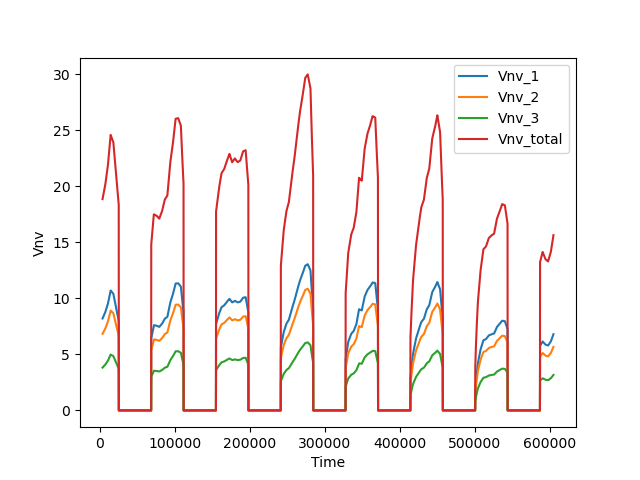

In [6]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

# B
Cd = np.zeros(len(alphas))
for i, alpha in enumerate(alphas):
    Cd[i] = get_Cd(np.radians(alpha), H, W)

Vnv = get_Vnv(Cd, As, Ls, JW['TintRec'], JW['Tout'], JW['time'])

# Plotting
plt.figure()

for i in range(3):
    plt.plot(JW['time'].flatten(), Vnv[i, :], label=f'Vnv_{i+1}')


plt.plot(JW['time'].flatten(), np.sum(Vnv, axis=0), label='Vnv_total')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Vnv')
plt.show()


## Problem 4

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_93722/2986799333.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_93722/2986799333.py:38: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Text(0, 0.5, 'Temperature [K]')

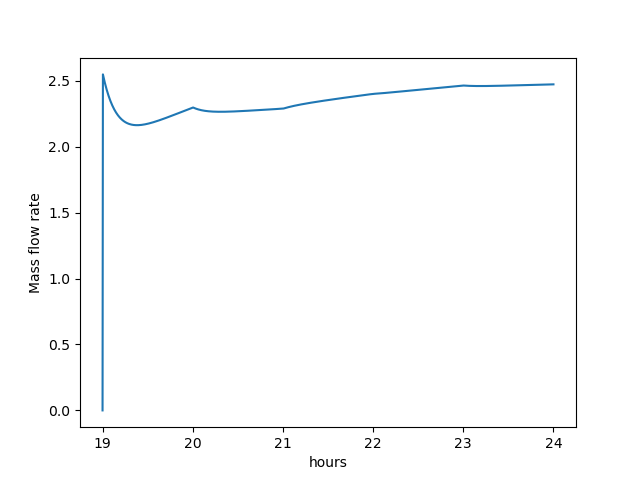

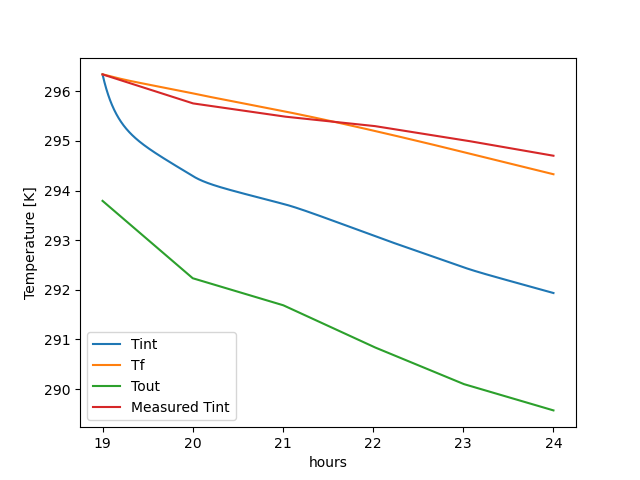

In [7]:
Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
N = len(times)
Tints = np.zeros(N)
Tints[0] = T_start
Touts = Q4['Tout'].flatten() + 273.15
Tf = T_start

T = np.ones(n) * Tf

T0s = np.zeros(N)
T0s[0] = Tf

Vnvs = np.zeros(N)

for i in range(1, N):
    t = times[i]
    hour = hours[i]
    Tint = Tints[i - 1]
    Tout = Touts[i - 1]
    b[0] = lambda_val * Tint / (1 + lambda_bound)
    b[-1] = b[0]
    T = np.dot(A, T) + b
    T0s[i] = get_T0(T[0], Tint, lambda_bound)

    Ef = 6 * Af * (T[0] - T0s[i]) / delx

    Vnv_total = np.sum(get_Vnv(Cd, As, Ls, Tint, Tout, t), axis=0)
    Evt = rho * Cp * Vnv_total * (Tout - Tint)
    Vnvs[i] = Vnv_total

    Tints[i] = Tint + lambda_int * (Ef + Eint + Evt)

# Plotting
plt.figure(6)
plt.plot(hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure(7)
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T0s, label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')